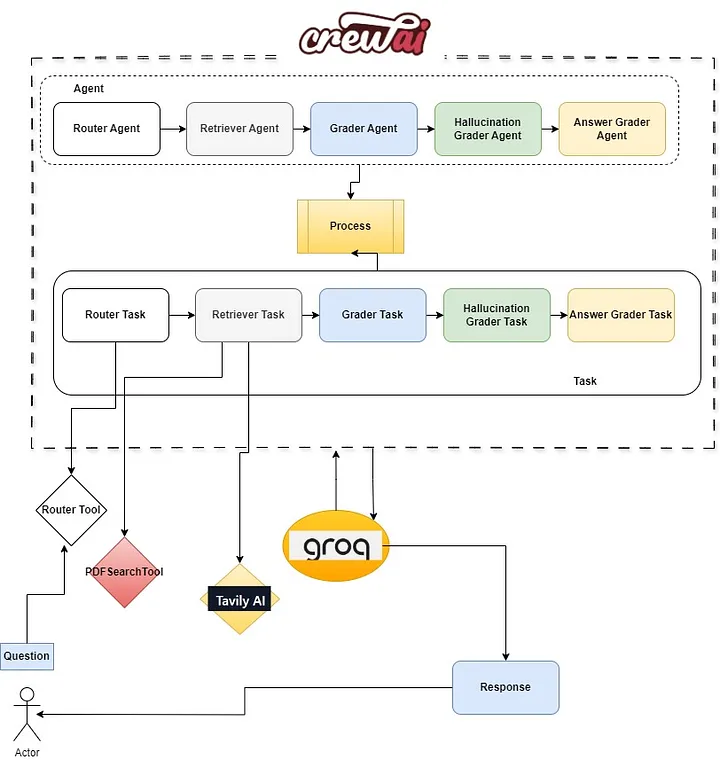

Here we will build a RAG Agent which will generate response for the question asked by retrieving relevant context if bthe question asked is about ESOPs otherwise the Agent will perform a web search to retrieve the required context and formulate a response that can be presented to the user.

**The RAG agent comprises of the following components:**

*  Router Agent: This agent decides whether to perform a RAG or external web search based on the context of the question asked.
*  Retriever Agent : This Agent retrieves context relevant to the question asked based on the mode suggested by the Router Agent.
*  Grader Agent: This Agent grades the context retrieved and check for the context relevancy with question asked.
*  Hallucination Grader Agent : This Agents grades the response from Retriever agent based on Usefulness and Facts
*  Answer Grader Agent: This Agent Generates the Final Response.
*  Router Task : Define task and expected output layout for Router Agent
*  Retriever Task: Define task and expected output layout for Retriever Agent
*  Grader Task : Define task and expected output layout for Grader Agent
*  Hallucination Grader Task: Define task and expected output layout for Hallucination Grader Agent
*  Answer Task : Define task and expected output layout for Answer grader Agent
*  Web Search Tool : Tool to perform external search
*  PDFSearchTool : CrewAI RAG tool designed for semantic searches within PDF content.
*  Llama3–8B as the Large Language Model

Code Implementation
Code implemented in Google Colab using CPU

Install Required Dependencies

In [ ]:
!pip install crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29 langchain-groq langchain-huggingface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 679.9 kB/s eta 0:00:00
INFO: pip is looking at multiple versions of langchain-groq to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of langchain-huggingface to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 1.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of embedchain to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of embedchain to determine which version is compatible with other requirements. This could take a while.
INFO: pip is l

**Libereies:**

In [ ]:
from google.colab import userdata
import os
from langchain_groq import ChatGroq
from crewai import Agent, Task, Crew, Process
from crewai_tools import SerperDevTool,PDFSearchTool,ScrapeWebsiteTool
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from google.colab import userdata
from crewai_tools  import tool
import os

 setup the API_KEY

In [ ]:

os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')#replace with your Groq api key

# Set the Tavily API key
os.environ['TAVILY_API_KEY'] = userdata.get("TAVILY_API_KEY")#replace with your Tavily Api Key
# os.environ["SERPER_API_KEY"]=userdata.get("SERPER_API_KEY")#replace with Serper Api Key

Setup the LLM

In [ ]:

llm=ChatGroq(model="llama-3.2-90b-text-preview")

In [ ]:
llm.invoke("How does exercise price determine for ESOP?")

AIMessage(content="The exercise price for an Employee Stock Option Plan (ESOP) is typically determined by the company's board of directors at the time of granting the options. The exercise price, also known as the strike price, is the price at which the employee can purchase the company's shares when they exercise their options.\n\nThere are a few common methods used to determine the exercise price for ESOP:\n\n1. **Fair Market Value (FMV)**: This is the most common method used to determine the exercise price. FMV is the price at which the company's shares would be traded on the open market at the time of granting the options. This price is usually determined by the company's auditors or a third-party valuation expert.\n2. **Grant Date Market Price**: This method uses the market price of the company's shares on the date the options are granted as the exercise price.\n3. **Average Market Price**: This method uses the average market price of the company's shares over a specified period (

Download input data for RAG(ESOP info)

In [ ]:
!wget "https://www.icsi.edu/media/webmodules/CSJ/January/17.pdf"

--2024-10-20 10:31:26--  https://www.icsi.edu/media/webmodules/CSJ/January/17.pdf
Resolving www.icsi.edu (www.icsi.edu)... 103.109.6.133
Connecting to www.icsi.edu (www.icsi.edu)|103.109.6.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 871378 (851K) [application/pdf]
Saving to: ‘17.pdf’

17.pdf              100%[===================>] 850.96K   762KB/s    in 1.1s    

2024-10-20 10:31:29 (762 KB/s) - ‘17.pdf’ saved [871378/871378]



***Create Tools***

Define the PDFSerachTool using custom model and embeddings

The PDFSearchTool is a RAG tool designed for semantic searches within PDF content. It allows for inputting a search query and a PDF document, leveraging advanced search techniques to find relevant content efficiently. This capability makes it especially useful for extracting specific information from large PDF files quickly.

In [ ]:

rag_tool = PDFSearchTool(pdf='/content/17.pdf',
    config=dict(
        llm=dict(
            provider="groq", # or google, openai, anthropic, llama2, ...
            config=dict(
                model="llama3-8b-8192",
                # temperature=0.5,
                # top_p=1,
                # stream=true,
            ),
        ),
        embedder=dict(
            provider="huggingface", # or openai, ollama, ...
            config=dict(
                model="BAAI/bge-small-en-v1.5",
                #task_type="retrieval_document",
                # title="Embeddings",
            ),
        ),
    )
)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Inserting batches in chromadb: 100%|██████████| 1/1 [00:12<00:00, 12.27s/it]


In [ ]:
rag_tool.run("How does exercise price determine for ESOP?")

Using Tool: Search a PDF's content


'Relevant Content:\noptions or shares. The employees are only able to obtain these shares once the ESOP vesting term has completed. Exercise period: It means the time period which starts after the completion of vesting period within which an employee can exercise his/her right to apply for shares against the vested options in pursuance of the scheme of ESOP approved by the shareholders in general meeting by way of Special Resolution. Exercise price: Means the price payable by an employee for exercising the options granted in pursuance of the scheme of ESOP. ARTICLE JANUARY 2024 | 107 CHARTERED SECRETARY\n\nESOP? A. Companies are free to decide the exercise price, which may be issued at a discount or premium but the exercise price determined by the Company shall not be less than the par value of the shares. Q. Does it mandatory for the Company to issue and allot only fresh shares under ESOP scheme? A. No, it is not mandatory for the company to issue and allot only fresh shares under ESO

Create Web Search Tool

In [ ]:
#set your Api keys
from langchain_community.tools.tavily_search import TavilySearchResults
search_tool=TavilySearchResults(k=3)
#
# search_tool= SerperDevTool()
# scrape_tool = ScrapeWebsiteTool()

Create Custom Tool to facilitate the Router Agent

In [ ]:
from crewai_tools  import tool
@tool
def router_tool(question):
  """Router Function"""
  if 'ESOP' in question:
    return 'vectorstore'
  else:
    return 'websearch'

Define our agents
Agent Parameters used :
Role : Defines the agent’s function within the crew. It determines the kind of tasks the agent is best suited for.
Goal : The individual objective that the agent aims to achieve. It guides the agent’s decision-making process.
Backstory :Provides context to the agent’s role and goal, enriching the interaction and collaboration dynamics.
LLM (optional): Represents the language model that will run the agent. It dynamically fetches the model name from the OPENAI_MODEL_NAME environment variable, defaulting to "gpt-4" if not specified.
Verbose (optional): Setting this to True configures the internal logger to provide detailed execution logs, aiding in debugging and monitoring. Default is False.
Allow Delegation (optional): Agents can delegate tasks or questions to one another, ensuring that each task is handled by the most suitable agent. Default is True.

router Agent


In [ ]:
Router_Agent = Agent(
  role='Router',
  goal='Route user question to a vectorstore or search the internet',
  backstory=(
    "You are an expert at routing a user question to a vectorstore or web search."
    "Use the vectorstore for questions on concept related to Retrieval-Augmented Generation."
    "You do not need to be stringent with the keywords in the question related to these topics. Otherwise, use web-search."
  ),
  verbose=True,
  allow_delegation=False,
  llm=llm,
)

2. Retriever Agent

In [ ]:
Retriever_agent = Agent(
    role="Retriever Agent",
    goal="Use the information retrieved from the vectorstore or web to answer the question",
    backstory=("You are an assistant for question-answering tasks."
    "Use the information present in the retrieved context to answer the question."
    "You have to provide a clear concise answer."
),
    verbose=True,
    allow_delegation=False,
    # tools=[rag_tool, search_tool, scrape_tool],  # Ensure vectorstore_tool, search_tool, and scrape_tool are correctly defined
    llm=llm,  # LLM for processing complex queries and handling context
    # action_handlers={
    #     "Search the internet": search_tool.run,  # Action for searching the
    #     "Scrape content": scrape_tool.run,  # Action for scraping detailed info from web
    #     "Search a PDF's content": rag_tool.run  # Action for retrieving from vectorstore
    # }
)

3. Grader Agent



In [ ]:
Grader_agent =  Agent(
  role='Answer Grader',
  goal='Filter out erroneous retrievals',
  backstory=(
    "You are a grader assessing relevance of a retrieved document to a user question."
    "If the document contains keywords related to the user question, grade it as relevant."
    "It does not need to be a stringent test.You have to make sure that the answer is relevant to the question."
  ),
  verbose=True,
  allow_delegation=False,
  llm=llm,
)

4. Hallucination Grader Agent

In [ ]:
hallucination_grader = Agent(
    role="Hallucination Grader",
    goal="Filter out hallucination",
    backstory=(
        "You are a hallucination grader assessing whether an answer is grounded in / supported by a set of facts."
        "Make sure you meticulously review the answer and check if the response provided is in alignmnet with the question asked"
    ),
    verbose=True,
    allow_delegation=False,
    llm=llm,
)

5. Answer Grader Agent

In [ ]:
answer_grader = Agent(
    role="Answer Grader",
    goal="Filter out hallucination from the answer.",
    backstory=(
        "You are a grader assessing whether an answer is useful to resolve a question."
        "Make sure you meticulously review the answer and check if it makes sense for the question asked"
        "If the answer is relevant generate a clear and concise response."
        "If the answer gnerated is not relevant then perform a websearch using 'web_search_tool'"
    ),
    verbose=True,
    allow_delegation=False,
    llm=llm,
)

**Define Tasks for the agents**

**Task Parameters**

*   Description: A clear, concise statement of what the task entails.
*  Agent: The agent responsible for the task, assigned either directly or by the crew’s process.
*   Expected Output: A detailed description of what the task’s completion looks like.
*   Tools (optional): The functions or capabilities the agent can utilize to perform the task
*   Context (optional): Specifies tasks whose outputs are used as context for this task.



1.Router Task

In [ ]:
router_task = Task(
    description=("Analyse the keywords in the question {question}"
    "Based on the keywords decide whether it is eligible either for vectorstore search or a web search using router_tool."
    "Return a single word 'vectorstore' if it is eligible for vectorstore search."
    "Return a single word 'websearch' if it is eligible for web search."
    "Do not provide any other premable or explaination."
    ),
    expected_output=("Give a binary choice 'websearch' or 'vectorstore' based on the question"
    "Do not provide any other premable or explaination."),
    agent=Router_Agent,
    tools=[router_tool],
    action_handlers={
        "router_tool": router_tool.run
    }
)

2. Retriever Task

In [ ]:

retriever_task = Task(
    description=("Based on the response from the router task extract information for the question {question} with the help of the respective tool."
    "In case the router task output is 'websearch' ,then  use the serach_tool to retrieve information from the web "
    "In case the router task output is 'vectorstore', then use the rag_tool to retrieve information from the vectorstore in case the router task output is 'vectorstore'."
                 ),
    expected_output=("You should analyse the output of the 'router_task"
    "If the response (output) is 'websearch' then use the Search the internet (search_tool) to retrieve information from the web."
    "If the response (output) is 'vectorstore' then use the Search a PDF's content (rag_tool) to retrieve information from the vectorstore."
    "Return a claer and consise text as response."),
    agent=Retriever_agent,
    content=[router_task],
    tools=[rag_tool,search_tool],# Ensure the router task provides context for the search
    action_handlers={
        "Search the internet": search_tool.run,  # Action for searching the
        "Search a PDF's content": rag_tool.run  # Action for retrieving from vectorstore
    }
    )



3. Grader Task

In [ ]:
grader_task = Task(
    description=("Based on the response from the retriever task for the quetion {question} evaluate whether the retrieved content is relevant to the question."
    ),
    expected_output=("Binary score 'yes' or 'no' score to indicate whether the document is relevant to the question"
    "You must answer 'yes' if the response from the 'retriever_task' is in alignment with the question asked."
    "You must answer 'no' if the response from the 'retriever_task' is not in alignment with the question asked."
    "Do not provide any preamble or explanations except for 'yes' or 'no'."),
    agent=Grader_agent,
    context=[retriever_task],
)

4. Hallucination Grader Task

In [ ]:
hallucination_task = Task(
    description=("Based on the response from the grader task for the quetion {question} evaluate whether the answer is grounded in / supported by a set of facts."),
    expected_output=("Binary score 'yes' or 'no' score to indicate whether the answer is sync with the question asked"
    "Respond 'yes' if the answer is in useful and contains fact about the question asked."
    "Respond 'no' if the answer is not useful and does not contains fact about the question asked."
    "Do not provide any preamble or explanations except for 'yes' or 'no'."),
    agent=hallucination_grader,
    context=[grader_task],
)

5. Answer grader Task

In [ ]:
answer_task = Task(
    description=("Based on the response from the hallucination task for the quetion {question} evaluate whether the answer is useful to resolve the question."
    "If the answer is 'yes' return a clear and concise answer."
    "If the answer is 'no' then perform a 'websearch' and return the response"),
    expected_output=("Return a clear and concise response if the response from 'hallucination_task' is 'yes'."
    "Perform a web search using 'web_search_tool' and return ta clear and concise response only if the response from 'hallucination_task' is 'no'."
    "Otherwise respond as 'Sorry! unable to find a valid response'."),
    context=[hallucination_task],
    agent=answer_grader,

)

**Setup the Crew**

In CrewAI, processes orchestrate the execution of tasks by agents, akin to project management in human teams. These processes ensure tasks are distributed and executed efficiently, in alignment with a predefined strategy

**Process Implementations**

*  Sequential: Executes tasks sequentially, ensuring tasks are completed in an orderly progression.
*  Hierarchical: Organizes tasks in a managerial hierarchy, where tasks are delegated and executed based on a structured chain of command. A manager language model (manager_llm) must be specified in the crew to enable the hierarchical process, facilitating the creation and management of tasks by the manager.
*  Consensual Process (Planned): Aiming for collaborative decision-making among agents on task execution, this process type introduces a democratic approach to task management within CrewAI. It is planned for future development and is not currently implemented in the codebase.
By default the process is implemented as a Sequential process if no process is mentioned.

In [ ]:
rag_crew = Crew(
    agents=[Router_Agent, Retriever_agent, Grader_agent, hallucination_grader, answer_grader],
    tasks=[router_task, retriever_task, grader_task, hallucination_task, answer_task],
    verbose=True,

)

Define the input

In [ ]:
inputs ={"question":"Does the ESOP supplement the salary of an employee?"}

***Kickoff the Crew***

In [ ]:
result = rag_crew.kickoff(inputs=inputs)

 [DEBUG]: == Working Agent: Router
 [INFO]: == Starting Task: Analyse the keywords in the question Does the ESOP supplement the salary of an employee?Based on the keywords decide whether it is eligible either for vectorstore search or a web search using router_tool.Return a single word 'vectorstore' if it is eligible for vectorstore search.Return a single word 'websearch' if it is eligible for web search.Do not provide any other premable or explaination.


> Entering new CrewAgentExecutor chain...
Thought: Analyzing the question to determine the suitable search method.

Action: router_tool
Action Input: {"question": "Does the ESOP supplement the salary of an employee?"} 

vectorstore

Thought: Analyzing the question to determine the suitable search method.
Action: router_tool
Action Input: {"question": "Does the ESOP supplement the salary of an employee?"} 

I tried reusing the same input, I must stop using this action input. I'll try something else instead.



Thought: Analyzing the k

In [ ]:
result

"Yes, the ESOP (Employee Stock Ownership Plan) can supplement the salary of an employee. An ESOP is a qualified employee benefit plan that allows employees to own shares of company stock, providing them with a potential additional source of income and a stake in the company's success. By granting employees ownership in the company, an ESOP can serve as a supplement to their regular salary, offering them a potential long-term financial benefit."

Let us test agent by agent functioning and completion
Test The Router Agent

In [ ]:
rag_crew = Crew(
    agents=[Router_Agent],
    tasks=[router_task],
    verbose=True,

)
inputs ={"question":"Does the ESOP supplement the salary of an employee?"}
result = rag_crew.kickoff(inputs=inputs)

 [DEBUG]: == Working Agent: Router
 [INFO]: == Starting Task: Analyse the keywords in the question Does the ESOP supplement the salary of an employee?Based on the keywords decide whether it is eligible either for vectorstore search or a web search using router_tool.Return a single word 'vectorstore' if it is eligible for vectorstore search.Return a single word 'websearch' if it is eligible for web search.Do not provide any other premable or explaination.


> Entering new CrewAgentExecutor chain...
Thought: Analyze the keywords in the question to decide on vectorstore or web search eligibility.

Action: router_tool
Action Input: {"question": "Does the ESOP supplement the salary of an employee?"} 

vectorstore

Thought: I now know the final answer
Final Answer: vectorstore

> Finished chain.
 [DEBUG]: == [Router] Task output: vectorstore




2. Test the Retriever Agent

In [ ]:
rag_crew = Crew(
    agents=[Router_Agent,Retriever_agent],
    tasks=[router_task,retriever_task],
    verbose=True,

)
inputs ={"question":"Does the ESOP supplement the salary of an employee?"}
result = rag_crew.kickoff(inputs)

 [DEBUG]: == Working Agent: Router
 [INFO]: == Starting Task: Analyse the keywords in the question Does the ESOP supplement the salary of an employee?Based on the keywords decide whether it is eligible either for vectorstore search or a web search using router_tool.Return a single word 'vectorstore' if it is eligible for vectorstore search.Return a single word 'websearch' if it is eligible for web search.Do not provide any other premable or explaination.


> Entering new CrewAgentExecutor chain...
Thought: I need to analyze the keywords in the question to determine the search type.

Action: router_tool
Action Input: {"input_text": "Does the ESOP supplement the salary of an employee?"} 

I encountered an error while trying to use the tool. This was the error: router_tool() got an unexpected keyword argument 'input_text'.
 Tool router_tool accepts these inputs: router_tool() - Router Function

Thought: I need to determine if the question is related to Retrieval-Augmented Generation conce

3. Test the Grader Agent

In [ ]:
rag_crew = Crew(
    agents=[Router_Agent,Retriever_agent,Grader_agent],
    tasks=[router_task,retriever_task,grader_task],
    verbose=True,

)
inputs ={"question":"ipl stand for ?"}
result = rag_crew.kickoff(inputs=inputs)

 [DEBUG]: == Working Agent: Router
 [INFO]: == Starting Task: Analyse the keywords in the question ipl stand for ?Based on the keywords decide whether it is eligible either for vectorstore search or a web search using router_tool.Return a single word 'vectorstore' if it is eligible for vectorstore search.Return a single word 'websearch' if it is eligible for web search.Do not provide any other premable or explaination.


> Entering new CrewAgentExecutor chain...
Thought: I need to determine whether the question "ipl stand for ?" is eligible for vectorstore search or web search.

Action: router_tool
Action Input: {"input_text": "ipl stand for ?", "task": "eligibility_check"} 

I encountered an error while trying to use the tool. This was the error: router_tool() got an unexpected keyword argument 'input_text'.
 Tool router_tool accepts these inputs: router_tool() - Router Function

Thought: I need to determine whether the question "ipl stand for ?" is eligible for vectorstore search or 

4. Test the Hallucination Grader Agent

In [ ]:
rag_crew = Crew(
    agents=[Router_Agent,Retriever_agent,Grader_agent,hallucination_grader],
    tasks=[router_task,retriever_task,grader_task,hallucination_task],
    verbose=True,

)
inputs ={"question":"Does the ESOP supplement the salary of an employee?"}
result = rag_crew.kickoff(inputs=inputs)

 [DEBUG]: == Working Agent: Router
 [INFO]: == Starting Task: Analyse the keywords in the question Does the ESOP supplement the salary of an employee?Based on the keywords decide whether it is eligible either for vectorstore search or a web search using router_tool.Return a single word 'vectorstore' if it is eligible for vectorstore search.Return a single word 'websearch' if it is eligible for web search.Do not provide any other premable or explaination.


> Entering new CrewAgentExecutor chain...
Thought: Analyzing the question to determine the type of search
Action: router_tool
Action Input: {"question": "Does the ESOP supplement the salary of an employee?"} 

vectorstore

Thought: I now know the final answer
Final Answer: websearch

> Finished chain.
 [DEBUG]: == [Router] Task output: websearch


 [DEBUG]: == Working Agent: Retriever Agent
 [INFO]: == Starting Task: Based on the response from the router task extract information for the question Does the ESOP supplement the salary of

5. Test the Answer Grader Agent

In [ ]:
rag_crew = Crew(
    agents=[Router_Agent,Retriever_agent,Grader_agent,hallucination_grader,answer_grader],
    tasks=[router_task,retriever_task,grader_task,hallucination_task,answer_task],
    verbose=True,

)
inputs ={"question":"Does the ESOP supplement the salary of an employee?"}
result = rag_crew.kickoff(inputs=inputs)

 [DEBUG]: == Working Agent: Router
 [INFO]: == Starting Task: Analyse the keywords in the question Does the ESOP supplement the salary of an employee?Based on the keywords decide whether it is eligible either for vectorstore search or a web search using router_tool.Return a single word 'vectorstore' if it is eligible for vectorstore search.Return a single word 'websearch' if it is eligible for web search.Do not provide any other premable or explaination.


> Entering new CrewAgentExecutor chain...
Thought: Analyze the question to determine if it's related to Retrieval-Augmented Generation or not.

Action: router_tool
Action Input: {"input_text": "Does the ESOP supplement the salary of an employee?"} 

I encountered an error while trying to use the tool. This was the error: router_tool() got an unexpected keyword argument 'input_text'.
 Tool router_tool accepts these inputs: router_tool() - Router Function

Thought: I will analyze the question to determine if it's related to Retrieval-A

Test the Agent with topic not related to ESOP

In [ ]:
rag_crew = Crew(
    agents=[Router_Agent, Retriever_agent, Grader_agent, hallucination_grader, answer_grader],
    tasks=[router_task, retriever_task, grader_task, hallucination_task, answer_task],
    verbose=True,

)
#
inputs = {"question":"What is Data Distributed Parallelism?"}
result = rag_crew.kickoff(inputs=inputs)

 [DEBUG]: == Working Agent: Router
 [INFO]: == Starting Task: Analyse the keywords in the question What is Data Distributed Parallelism?Based on the keywords decide whether it is eligible either for vectorstore search or a web search using router_tool.Return a single word 'vectorstore' if it is eligible for vectorstore search.Return a single word 'websearch' if it is eligible for web search.Do not provide any other premable or explaination.


> Entering new CrewAgentExecutor chain...
Thought: I need to analyze the keywords in the question to determine if it's eligible for vectorstore search or web search.
Action: router_tool
Action Input: {"input_text": "What is Data Distributed Parallelism?"} 

I encountered an error while trying to use the tool. This was the error: router_tool() got an unexpected keyword argument 'input_text'.
 Tool router_tool accepts these inputs: router_tool() - Router Function

Thought: I should use the router_tool function to route the question to either vectors

Testing the Agent on a new question related to ESOP

In [ ]:
rag_crew = Crew(
    agents=[Router_Agent, Retriever_agent, Grader_agent, hallucination_grader, answer_grader],
    tasks=[router_task, retriever_task, grader_task, hallucination_task, answer_task],
    verbose=True,

)
#
inputs = {"question":"How does exercise price determine for ESOP?"}
result = rag_crew.kickoff(inputs=inputs)

 [DEBUG]: == Working Agent: Router
 [INFO]: == Starting Task: Analyse the keywords in the question How does exercise price determine for ESOP?Based on the keywords decide whether it is eligible either for vectorstore search or a web search using router_tool.Return a single word 'vectorstore' if it is eligible for vectorstore search.Return a single word 'websearch' if it is eligible for web search.Do not provide any other premable or explaination.


> Entering new CrewAgentExecutor chain...
Thought: I need to analyze the keywords in the question to decide whether it's eligible for vectorstore search or a web search.

Action: router_tool
Action Input: {"question": "How does exercise price determine for ESOP?"} 

vectorstore

Thought: I now know the final answer
Final Answer: vectorstore

> Finished chain.
 [DEBUG]: == [Router] Task output: vectorstore


 [DEBUG]: == Working Agent: Retriever Agent
 [INFO]: == Starting Task: Based on the response from the router task extract information fo

In [ ]:
result

"The exercise price for Employee Stock Option Plans (ESOPs) is typically determined by the company's board of directors or compensation committee. It is usually set at or around the fair market value of the company's stock on the date the option is granted. This price is often determined by an independent appraisal or based on the closing price of the company's stock on the date of grant. The exercise price is an important factor in determining the value of the option, as it affects the potential profit an employee can realize by exercising the option and selling the stock."